# Importing necessary libraries

In [3]:
import pandas as pd
import seaborn as sns
from functools import lru_cache
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# Loading the dataset

**Examining variable types**: 
1. **Numerical Variables:** These include mapped_veh_id, various sensor readings like RS_E_InAirTemp_PC1, geographical coordinates (lat, lon), environmental data (Temperature, Humidity, Rain), etc.

2. **Object Variables:** timestamps_floor and Time are datetime objects but are currently read as strings. We need to convert these to datetime format for any time-series analysis.

In [4]:
file_path = '/kaggle/input/dataset-sncb/dataset_ar41_for_ulb.csv'
data = pd.read_csv(file_path)

# Checking duplicate values in the dataset

The dataset doesn't contain any NULL values, duplicate rows

In [ ]:
duplicate_rows = data.duplicated()

# Performing statistical analysis

1. **Data Scale and Variety:** The dataset is large around 17.6 million rows and contains a variety of measurements, including geographical data (latitude, longitude), Two engine parameters (air temperature, oil pressure, RPM, water temperature, oil temperature), and environmental factors (external temperature, humidity, rain).

2. **Potential Outliers:** The maximum values for some parameters (e.g., RS_E_InAirTemp_PC1, RS_E_InAirTemp_PC2 with values like 65535) and they indicates the presence of outliers

2. **Data Distribution:** The standard deviation (std) indicates the spread of the data, which is crucial for understanding the variability in each feature. This will impact how the K-means algorithm assigns data points to clusters.

In [9]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
descriptive_stats = data[['RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2','RS_E_OilPress_PC1', 'RS_E_OilPress_PC2', 'RS_E_RPM_PC1', 'RS_E_RPM_PC2', 'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2']].describe()
print(descriptive_stats)

       RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  RS_E_OilPress_PC1  \
count      17666508.00000      17666508.00000     17666508.00000   
mean             32.02987            32.33412          263.58789   
std             328.12210           347.99953          115.18088   
min               0.00000             0.00000            0.00000   
25%              22.00000            22.00000          203.00000   
50%              32.00000            33.00000          238.00000   
75%              40.00000            39.00000          320.00000   
max           65535.00000         65535.00000          690.00000   

       RS_E_OilPress_PC2   RS_E_RPM_PC1   RS_E_RPM_PC2  RS_E_WatTemp_PC1  \
count     17666508.00000 17666508.00000 17666508.00000    17666508.00000   
mean           270.68750      912.38797      907.96387          76.94352   
std            116.11669      383.30365      388.47031          13.63081   
min              0.00000        0.00000        0.00000         -15.00000   
25%    


**First Set of Variables:**

The distributions for RS_E_InAirTemp_PC1 and RS_E_InAirTemp_PC2 show some extreme values (likely outliers) concentrated at the higher end.

RS_E_WatTemp_PC1 and RS_E_WatTemp_PC2 display more normally distributed values, with a slight skew towards higher temperatures.

The oil temperature variables (RS_T_OilTemp_PC1, RS_T_OilTemp_PC2) also exhibit a fairly normal distribution, again with a slight tendency towards higher values.

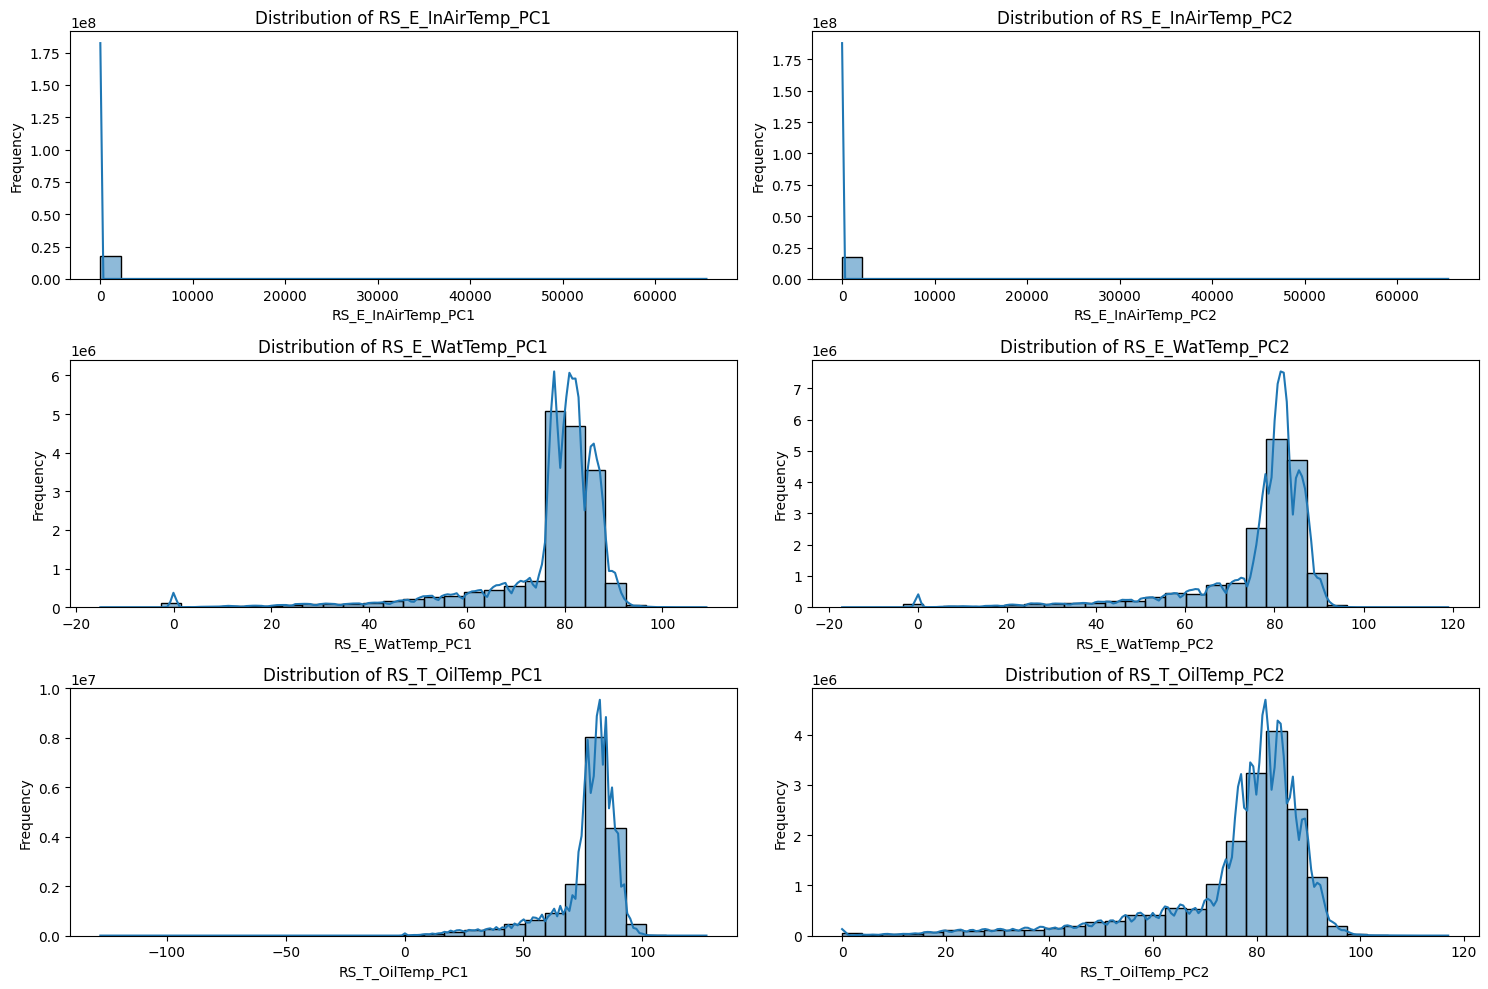

In [6]:
selected_variables = ['RS_E_InAirTemp_PC1','RS_E_InAirTemp_PC2', 'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC1','RS_T_OilTemp_PC2']

plt.figure(figsize=(15, 10))

for i, var in enumerate(selected_variables):
    plt.subplot(3, 2, i+1)
    sns.histplot(data[var], kde=True, bins=30)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

**Second Set of Variables:**

RS_E_OilPress_PC1 and RS_E_OilPress_PC2 have a multi-modal distribution with distinct peaks, suggesting different operational states or conditions.

The RPM variables (RS_E_RPM_PC1, RS_E_RPM_PC2) show a concentration of values at lower RPMs with a long tail towards higher RPMs. This could indicate a few instances of high engine activity.

The Temperature variable is fairly normally distributed, indicating a range of environmental conditions during the data collection period.

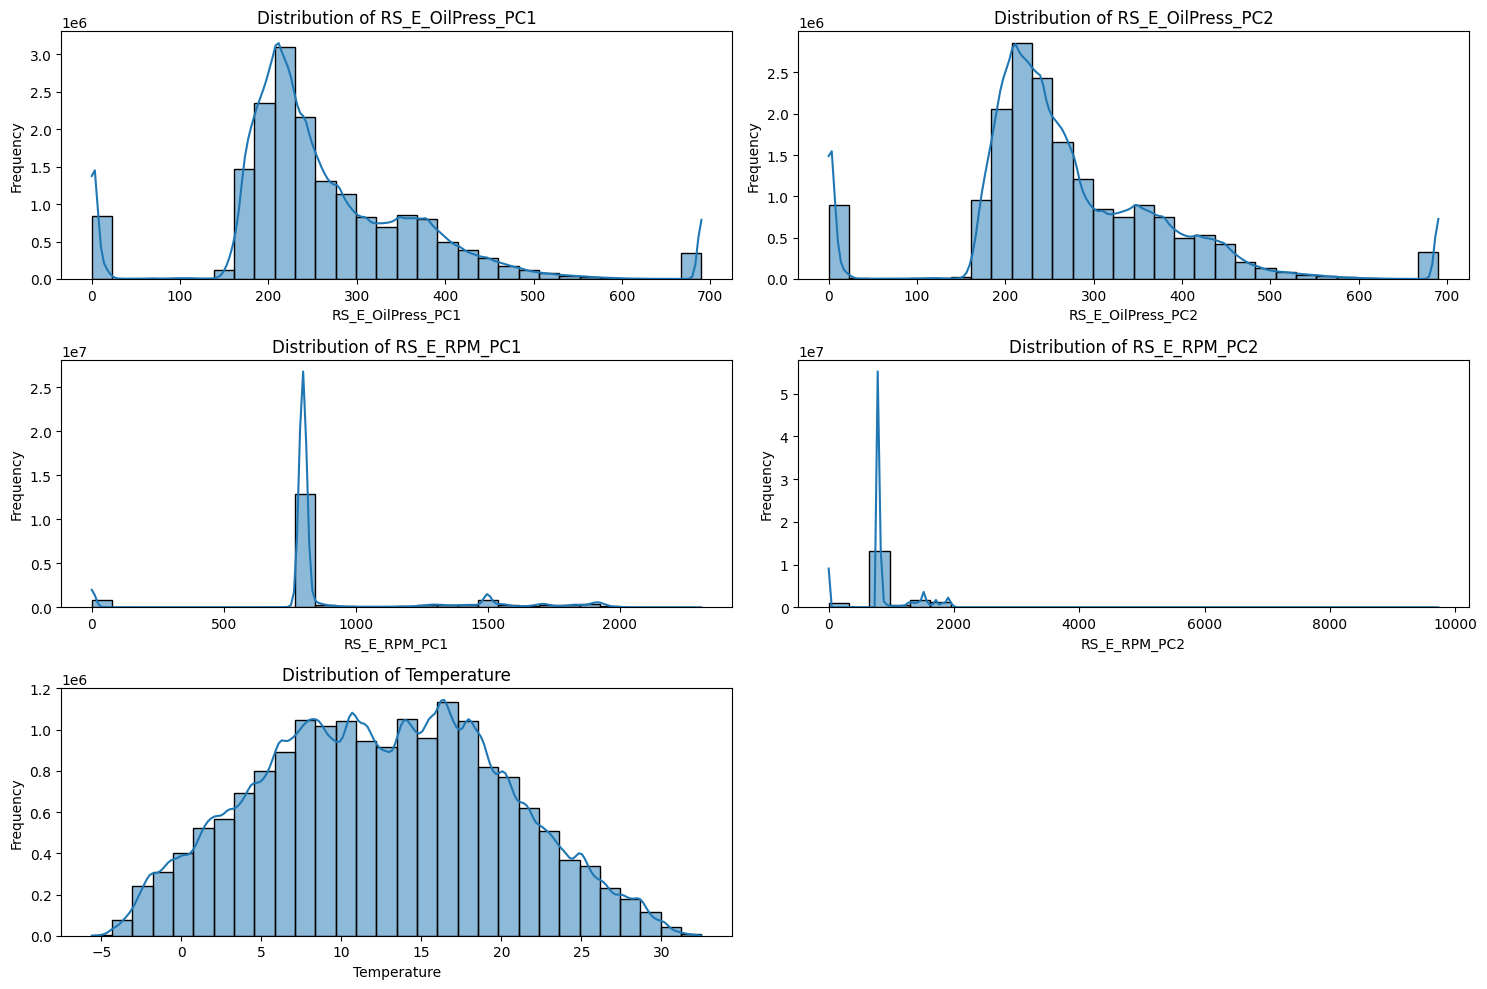

In [15]:
selected_variables = ['RS_E_OilPress_PC1','RS_E_OilPress_PC2', 'RS_E_RPM_PC1', 'RS_E_RPM_PC2', 'Temperature']

plt.figure(figsize=(15, 10))

for i, var in enumerate(selected_variables):
    plt.subplot(3, 2, i+1)
    sns.histplot(data[var], kde=True, bins=30)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Feature Selection

Engine Air and Water Temperatures: RS_E_InAirTemp_PC1, RS_E_InAirTemp_PC2, RS_E_WatTemp_PC1, and RS_E_WatTemp_PC2. These are directly related to the cooling efficiency and engine health.

Oil Temperatures: RS_T_OilTemp_PC1 and RS_T_OilTemp_PC2. High oil temperatures indicate cooling system malfunctions or excessive engine stress.

Oil Pressure: RS_E_OilPress_PC1 and RS_E_OilPress_PC2. Although not directly correlated with RPMs, oil pressure is crucial for engine performance and safety.

RPM Variables: RS_E_RPM_PC1 and RS_E_RPM_PC2. RPMs can be indicative of engine performance and potential stressors.

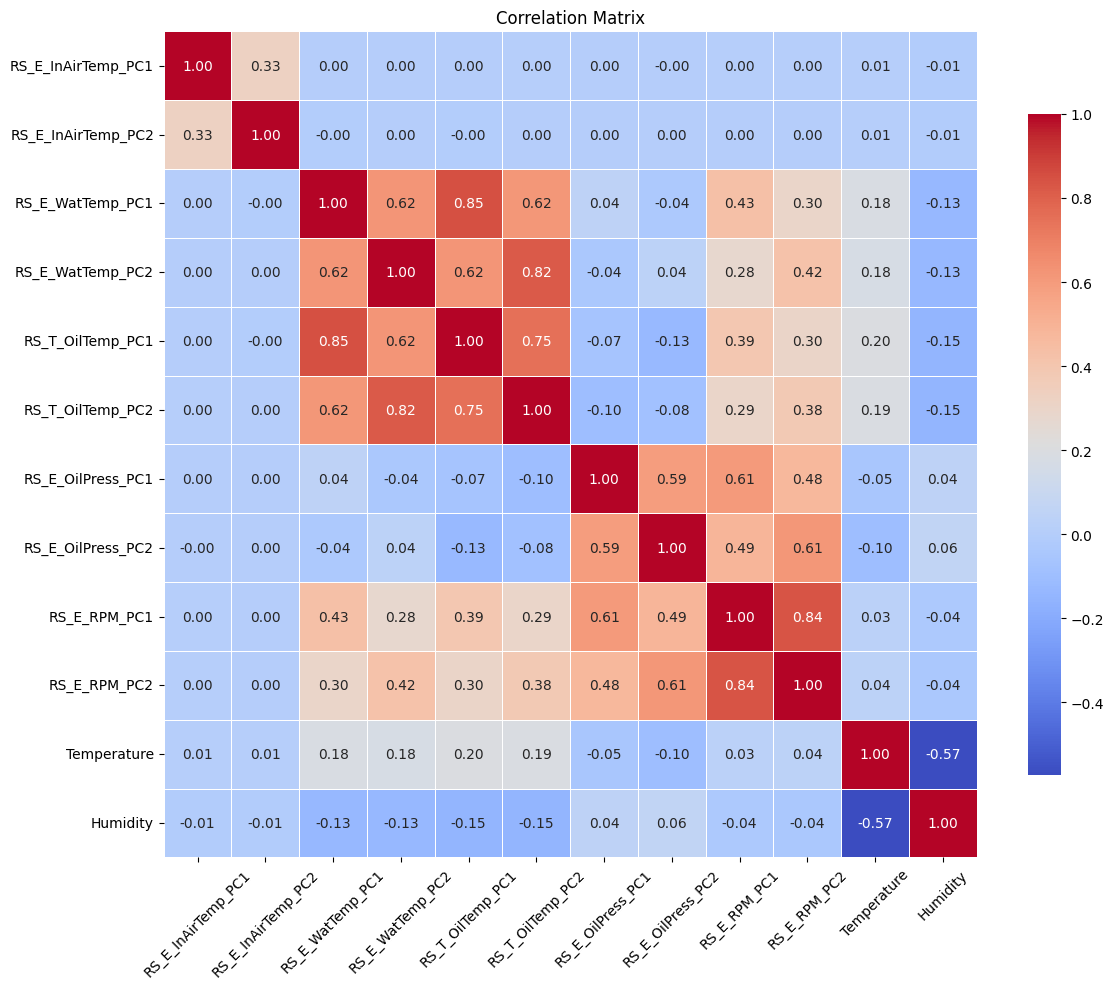

In [17]:
features = ['RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 'RS_E_WatTemp_PC1', 
                     'RS_E_WatTemp_PC2', 'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2', 'RS_E_OilPress_PC1', 
                   'RS_E_OilPress_PC2', 'RS_E_RPM_PC1', 'RS_E_RPM_PC2', 'Temperature', 'Humidity']


correlation_matrix = data[features].corr()

plt.figure(figsize=(12, 10))  # Adjusted size
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            linewidths=.5, cbar_kws={"shrink": .8})
plt.xticks(rotation=45)
plt.yticks(rotation=0) 
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('/kaggle/working/correlation_matrix.png', dpi=300)
plt.show()

# Feature Enigneering
As per the project description, if the temperature reading of these variable goes above the threshold values it indicates temperature anomalies. Therefore, creating a new feature by indicating 0 for not-anomaly and 1 for anomaly

In [134]:
# Set threshold values as provided
AIR_TEMP_THRESHOLD = 65
WATER_TEMP_THRESHOLD = 100
OIL_TEMP_THRESHOLD = 115

data['Air_Temp_Exceed_PC1'] = (data['RS_E_InAirTemp_PC1'] > AIR_TEMP_THRESHOLD).astype(int)
data['Water_Temp_Exceed_PC1'] = (data['RS_E_WatTemp_PC1'] > WATER_TEMP_THRESHOLD).astype(int)
data['Oil_Temp_Exceed_PC1'] = (data['RS_T_OilTemp_PC1'] > OIL_TEMP_THRESHOLD).astype(int)

data['Air_Temp_Exceed_PC2'] = (data['RS_E_InAirTemp_PC2'] > AIR_TEMP_THRESHOLD).astype(int)
data['Water_Temp_Exceed_PC2'] = (data['RS_E_WatTemp_PC2'] > WATER_TEMP_THRESHOLD).astype(int)
data['Oil_Temp_Exceed_PC2'] = (data['RS_T_OilTemp_PC2'] > OIL_TEMP_THRESHOLD).astype(int)

# Differentiate two engine parameter

1. Differentiate oil pressure record of both the engine as they seems correlated.
2. Differentiate RPM values of both the engine.

Differentiating to reduce the features to feed into k means clustering

In [135]:
# data['Air_Temp_Diff'] = abs(data['RS_E_InAirTemp_PC1'] - data['RS_E_InAirTemp_PC2'])
# data['Water_Temp_Diff'] = abs(data['RS_E_WatTemp_PC1'] - data['RS_E_WatTemp_PC2'])
# data['Oil_Temp_Diff'] = abs(data['RS_T_OilTemp_PC1'] - data['RS_T_OilTemp_PC2'])
data['RPM_Diff'] = abs(data['RS_E_RPM_PC1'] - data['RS_E_RPM_PC2'])
data['Oil_Press_Diff'] = abs(data['RS_E_OilPress_PC1'] - data['RS_E_OilPress_PC2'])

# Data Normalization

Z-score normalize data points by scaling down the data points to its mean(0) and standard deviation(1). As the dataset contains global outliers where can be anoamlies can happens

In [136]:
# data['Air_Temp_Diff_Z'] = zscore(data['Air_Temp_Diff'])
# data['Water_Temp_Diff_Z'] = zscore(data['Water_Temp_Diff'])
# data['Oil_Temp_Diff_Z'] = zscore(data['Oil_Temp_Diff'])
data['Oil_Press_Diff_Z'] = zscore(data['Oil_Press_Diff'])
data['RPM_Diff_Z'] = zscore(data['RPM_Diff'])
# data['Temperature_Z'] =zscore(data['Temperature'])

In [137]:
scaler = MinMaxScaler()
data[['Temperature_MinMax']] = scaler.fit_transform(data[['Temperature']])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

In [138]:
selecting_features = ['Air_Temp_Exceed_PC1', 'Water_Temp_Exceed_PC1','Oil_Temp_Exceed_PC1', 
                      'Air_Temp_Exceed_PC2','Water_Temp_Exceed_PC2','Oil_Temp_Exceed_PC2',
                      'RPM_Diff_Z', 'Oil_Press_Diff_Z', 'Temperature_MinMax']
relevant_features = data[selecting_features]

# Applying PCA technique to reduce the dimensionality 

Here we can see that the first two PCA capture almost 98% of the information from the selected features, therefore, considering only the PCA1 and PCA2 is ideal.

In [139]:
pca = PCA(n_components=2)

pca.fit(relevant_features)

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

print(cumulative_explained_variance)
pca_data = pca.transform(relevant_features)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


[0.72164293 0.978961  ]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


# Visualizing PCA

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


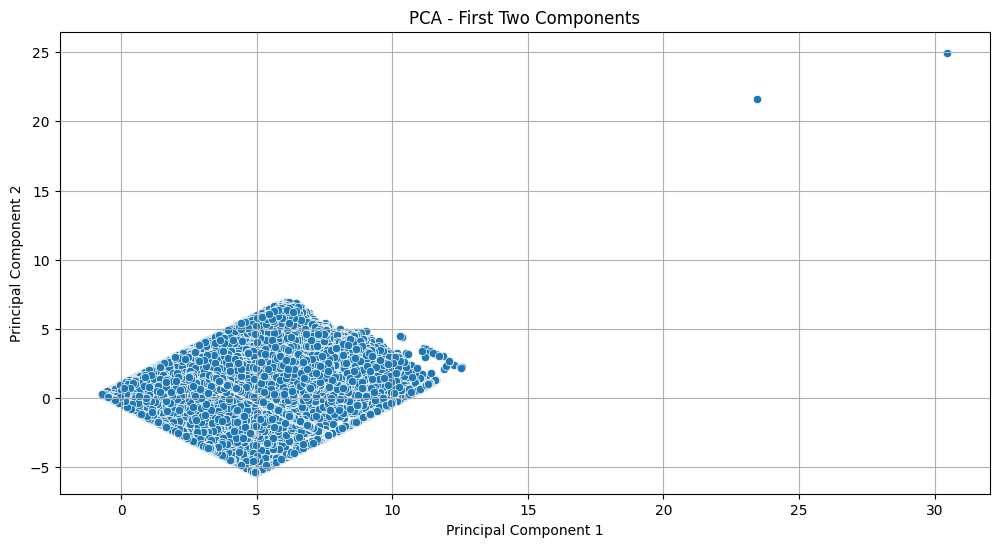

In [140]:
pca_columns = ['PCA' + str(i+1) for i in range(pca_data.shape[1])]
pca_df = pd.DataFrame(pca_data, columns=pca_columns)

plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', data=pca_df)
plt.title('PCA - First Two Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

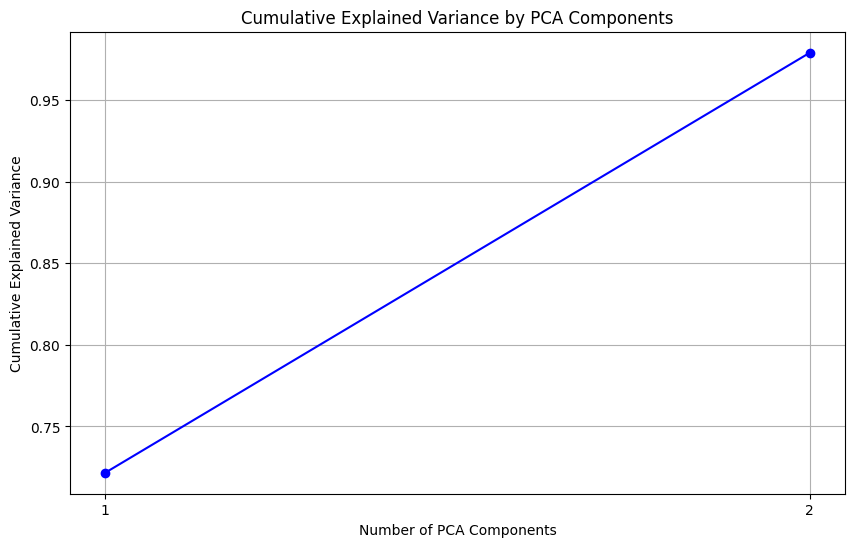

In [141]:
n_components = range(1, len(cumulative_explained_variance) + 1)

plt.figure(figsize=(10, 6))
plt.plot(n_components, cumulative_explained_variance, marker='o', linestyle='-', color='b')

plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(n_components)
plt.grid(True)
plt.show()

# Applying Elbow Method to find the optimal value of k for k means clustering

We can see that the value of WCSS decreases rapidly after second cluster, so we are considering taking the k=2 for k means cluster.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

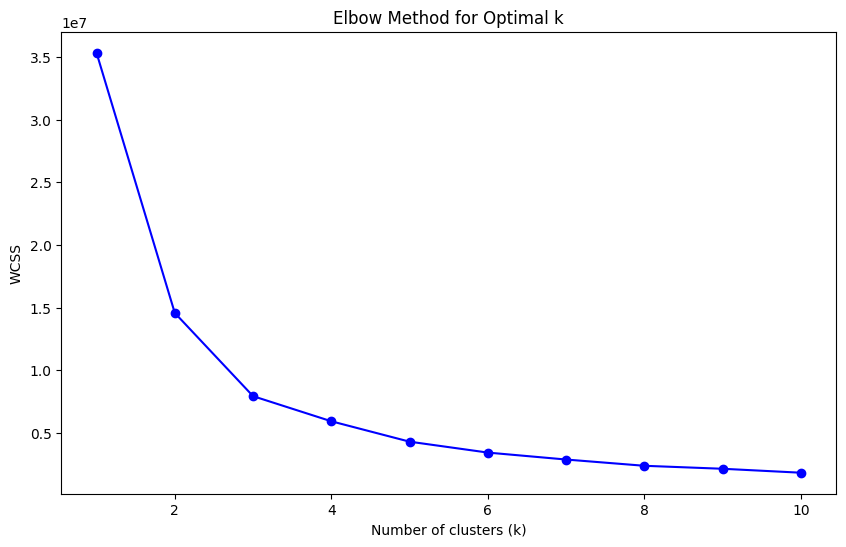

In [142]:
k_values = range(1, 11) 

wcss = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(pca_data) 
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, 'bo-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

In [143]:
k_optimal = 3

kmeans_optimal = KMeans(n_clusters=k_optimal, init='k-means++', random_state=42)

kmeans_optimal.fit(pca_data)

cluster_labels = kmeans_optimal.labels_

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [144]:
loadings = pd.DataFrame(pca.components_.T, index=relevant_features.columns, columns=['PC{}'.format(i+1) for i in range(len(pca.components_))])
print("PCA Component Loadings:\n", loadings)

PCA Component Loadings:
                             PC1       PC2
Air_Temp_Exceed_PC1    0.002785  0.003583
Water_Temp_Exceed_PC1  0.000107  0.000186
Oil_Temp_Exceed_PC1    0.000008  0.000006
Air_Temp_Exceed_PC2    0.003948  0.004381
Water_Temp_Exceed_PC2  0.000033  0.000029
Oil_Temp_Exceed_PC2    0.000003  0.000005
RPM_Diff_Z             0.707058  0.707084
Oil_Press_Diff_Z       0.707111 -0.706926
Temperature_MinMax    -0.006339  0.016013


In [145]:
centroids = pca.inverse_transform(kmeans_optimal.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=relevant_features.columns)
print("\nCluster Centroids in Original Feature Space:\n", centroids_df)


Cluster Centroids in Original Feature Space:
    Air_Temp_Exceed_PC1  Water_Temp_Exceed_PC1  Oil_Temp_Exceed_PC1  \
0             0.001390               0.000057         7.717431e-07   
1             0.018869               0.000793         4.445139e-05   
2            -0.000748              -0.000176         7.378399e-06   

   Air_Temp_Exceed_PC2  Water_Temp_Exceed_PC2  Oil_Temp_Exceed_PC2  \
0             0.001583               0.000015         2.369014e-07   
1             0.025404               0.000205         2.156364e-05   
2             0.000741               0.000034        -3.694152e-06   

   RPM_Diff_Z  Oil_Press_Diff_Z  Temperature_MinMax  
0   -0.208591         -0.230755            0.478357  
1    3.950534          1.983879            0.471811  
2   -0.116432          4.292323            0.407490  


# Reverse Feature Inspection

1. Temperature Exceedance Indicators: 
Clusters 0 and 2 have very low values for Air_Temp_Exceed_PC1, Water_Temp_Exceed_PC1, Oil_Temp_Exceed_PC1, and their counterparts for PC2. This suggests that these clusters represent operational states with minimal temperature-related anomalies.
Cluster 1, however, shows significantly higher values for these indicators, particularly Air_Temp_Exceed_PC2. This implies that Cluster 1 likely represents operational states where temperature anomalies, especially in air temperature, are more frequent.
2. RPM and Oil Pressure Differences (Denormalized):
RPM Difference:
Cluster 0: Shows a relatively small RPM difference (18.5), suggesting similar operational speeds or loads on both engines.
Cluster 2: Has a moderate RPM difference (37.9), indicating some variance in engine operations but not as pronounced as in Cluster 1.
Cluster 1: Exhibits a very high RPM difference (897.2), pointing to significant discrepancies in engine operation, possibly due to high-stress conditions or differing engine performances.

3. Oil Pressure Difference:
Cluster 0: Shows a small difference in oil pressure (39.9), indicating consistent and normal operational conditions.
Cluster 2: Has a very high oil pressure difference (429.4), which might indicate an operational issue or a specific condition where one engine is under much more stress than the other.
Cluster 1: Also shows a considerable oil pressure difference (230.6), further supporting the notion of varied engine stress or performance within this cluster.

4. Temperature (Denormalized):
The Temperature values are relatively similar across all clusters, suggesting that external environmental temperature variations aren't the primary differentiators for these clusters.

In [154]:
# centroids_df['Air_Temp_Diff'] = centroids_df['Air_Temp_Diff_Z'] * data['Air_Temp_Diff'].std() + data['Air_Temp_Diff'].mean()
# centroids_df['Water_Temp_Diff'] = centroids_df['Water_Temp_Diff_Z'] * data['Water_Temp_Diff'].std() + data['Water_Temp_Diff'].mean()
# centroids_df['Oil_Temp_Diff'] = centroids_df['Oil_Temp_Diff_Z'] * data['Oil_Temp_Diff'].std() + data['Oil_Temp_Diff'].mean()
centroids_df['RPM_Diff'] = centroids_df['RPM_Diff_Z'] * data['RPM_Diff'].std() + data['RPM_Diff'].mean()
centroids_df['Oil_Press_Diff'] = centroids_df['Oil_Press_Diff_Z'] * data['Oil_Press_Diff'].std() + data['Oil_Press_Diff'].mean()

centroids_df['Temperature'] = scaler.inverse_transform(centroids_df[['Temperature_MinMax']])

centroids_df[['RPM_Diff', 'Oil_Press_Diff', 'Temperature']]
pd.set_option('display.float_format', lambda x: '%.5f' % x)
print("Denormalized Centroids:\n", centroids_df)

Denormalized Centroids:
    Air_Temp_Exceed_PC1  Water_Temp_Exceed_PC1  Oil_Temp_Exceed_PC1  \
0              0.00139                0.00006              0.00000   
1              0.01887                0.00079              0.00004   
2             -0.00075               -0.00018              0.00001   

   Air_Temp_Exceed_PC2  Water_Temp_Exceed_PC2  Oil_Temp_Exceed_PC2  \
0              0.00158                0.00001              0.00000   
1              0.02540                0.00021              0.00002   
2              0.00074                0.00003             -0.00000   

   RPM_Diff_Z  Oil_Press_Diff_Z  Temperature_MinMax  RPM_Diff  Oil_Press_Diff  \
0    -0.20859          -0.23076             0.47836  18.50677        39.89055   
1     3.95053           1.98388             0.47181 897.22450       230.63146   
2    -0.11643           4.29232             0.40749  37.97750       429.45193   

   Temperature  
0     12.62542  
1     12.37600  
2      9.92537  


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


5. Cluster 0 is characterized by minimal temperature anomalies and small differences in RPM and oil pressure. This cluster likely represents normal operational conditions.
6. Cluster 2 shows minimal temperature anomalies but has a very high oil pressure difference, indicating potential issues or specific operational states that don't necessarily lead to overheating but could signify other types of stress or inefficiency in the cooling system.
7. Cluster 1 is marked by more frequent temperature anomalies, particularly in air temperature, along with high differences in RPM and oil pressure. This cluster is indicative of high-stress operational states or potential issues in the cooling system, where there are significant discrepancies in engine operations and more frequent overheating incidents.

In [ ]:
pca_df['Cluster'] = cluster_labels
sampled_pca_df = pca_df.sample(n=10000, random_state=42)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='viridis', data=sampled_pca_df, legend='full')

for i in range(k_optimal):
    cluster_data = sampled_pca_df[sampled_pca_df['Cluster'] == i]
    centroid = cluster_data[['PCA1', 'PCA2']].mean()
    plt.scatter(centroid['PCA1'], centroid['PCA2'], marker='*', color='red', s=200, label=f'Centroid {i}' if i == 0 else None)

plt.title('Scatter Plot of Clusters with Anomalies Highlighted')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

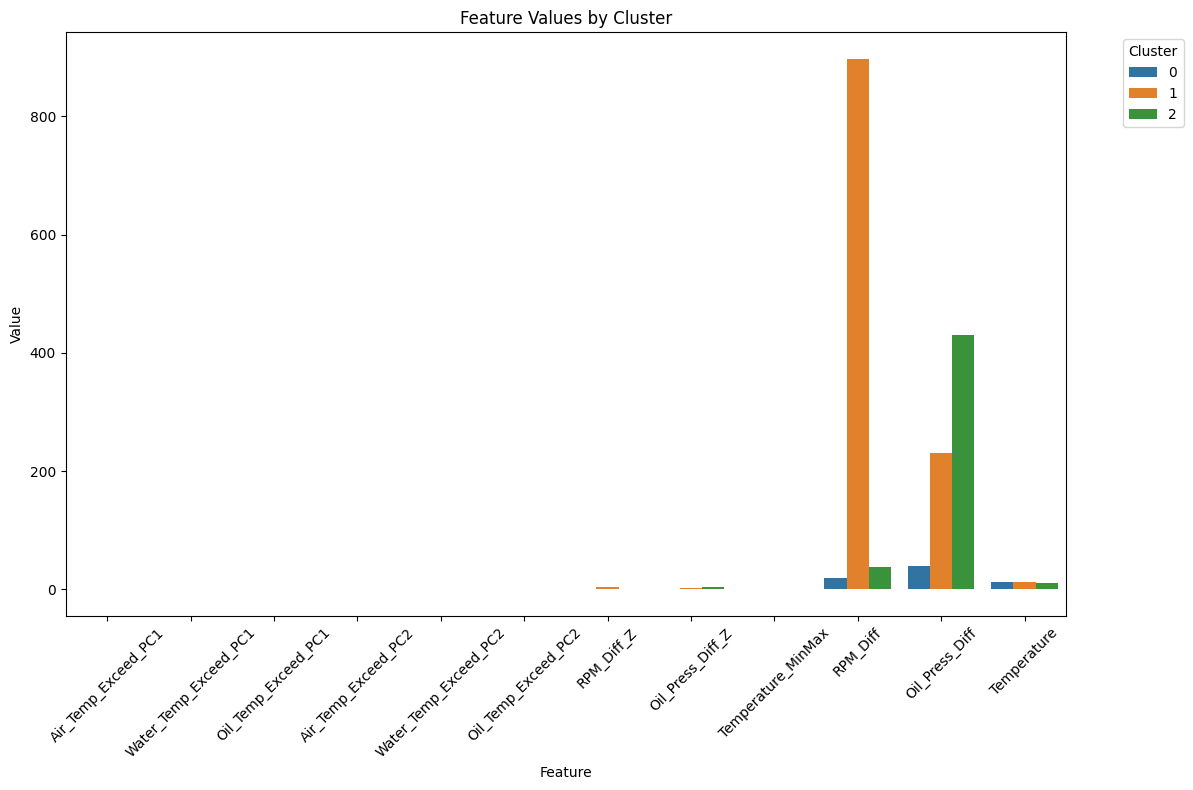

In [149]:
# Create a long-form DataFrame for plotting with seaborn
long_df = centroids_df.reset_index().melt(id_vars='index')
long_df.rename(columns={'index': 'Cluster'}, inplace=True)

# Plotting with seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=long_df, x='variable', y='value', hue='Cluster')
plt.title('Feature Values by Cluster')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Feature Inspection


In [151]:
centroids = kmeans_optimal.cluster_centers_
distances = cdist(pca_data, centroids, 'euclidean')


min_distances = np.min(distances, axis=1)
#statistical method 
distance_mean = np.mean(min_distances)
distance_std = np.std(min_distances)
anomaly_threshold = distance_mean + 3 * distance_std

anomaly_threshold = np.percentile(min_distances, 95)

anomalies = min_distances > anomaly_threshold

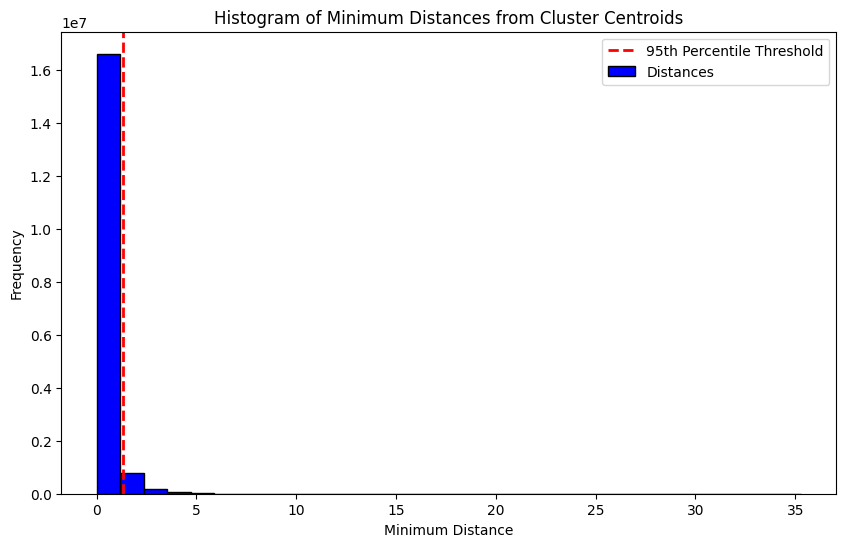

In [152]:
# Plotting the histogram of minimum distances
plt.figure(figsize=(10, 6))
plt.hist(min_distances, bins=30, color='blue', edgecolor='black')
plt.axvline(anomaly_threshold, color='red', linestyle='dashed', linewidth=2)
plt.title('Histogram of Minimum Distances from Cluster Centroids')
plt.xlabel('Minimum Distance')
plt.ylabel('Frequency')
plt.legend(['95th Percentile Threshold', 'Distances'])
plt.show()